---

# II. SEGMENTACIÓN DE TRANSLUCENCIA NUCAL

El objetivo de esta segunda parte del trabajo es lograr entrenar una red neuronal que sea capaz de segmentar de la manera más precisa posible el area anecogénica de la Translucencia Nucal (TN). 
Para ello, se utilizarán las segmentaciones hechas a partir de las bounding boxes del training set original. Este procese se encuentra deetallado en el notebook de anexo `segmentation_from_bb.ipynb`.
A partir de ello, se entrenó un modelo de segmentación semántica basado en la arquitectura U-NET

U-net for the segmentation of NT 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Rescaling
from tensorflow.image import resize
import os 
import cv2

## Pipeline de segmentación del training set

Como se indicó anteriormente, la segmentación propiamente dicha de las imágenes del training set se realizó a partir de las bounding boxes originales. El dataset original no contaba con estas segmentaciones, por lo que se tuvo que diseñar un proceso para extraerlas. La segmentación se realizó de la siguiente manera:

1. Aplicar el denoising anteriormente explicado
2. Aumentar el constraste con CLAHE
3. Aplicar un filtro pasa altos
4. Binarizar la sección de interés de la imagen (interna a la bounding box conocida) por Otsu
5. Mejorar la binarización por apertura y cierre
5. Aplicar etiquetado sobre las secciones encontradas
6. Seleccionar la etiqueta que corresponde a la TN como aquella con mayor área
7. Tomar el centroide de esta etiqueta 
8. Aplicar region growing a la imágen original partiendo de dicho punto
9. Si el área de la segmentación es muy pequeña, mover la semilla aleatoriamente y repetir el region growing



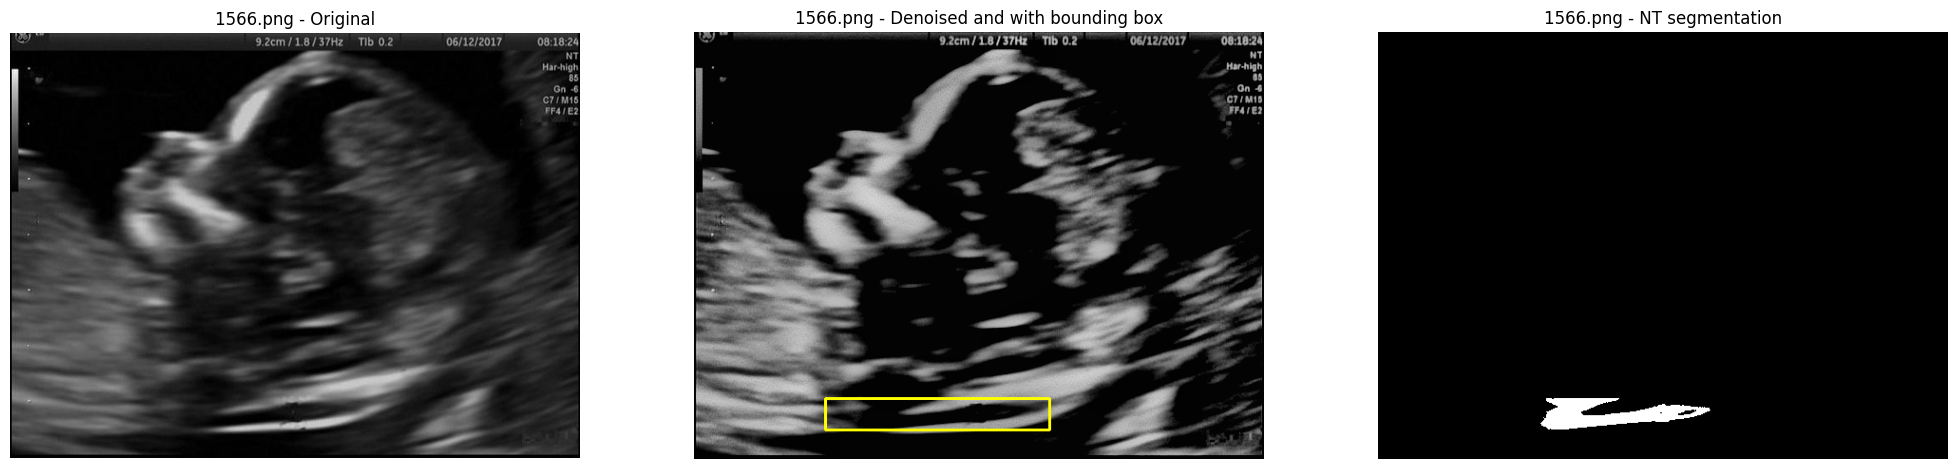

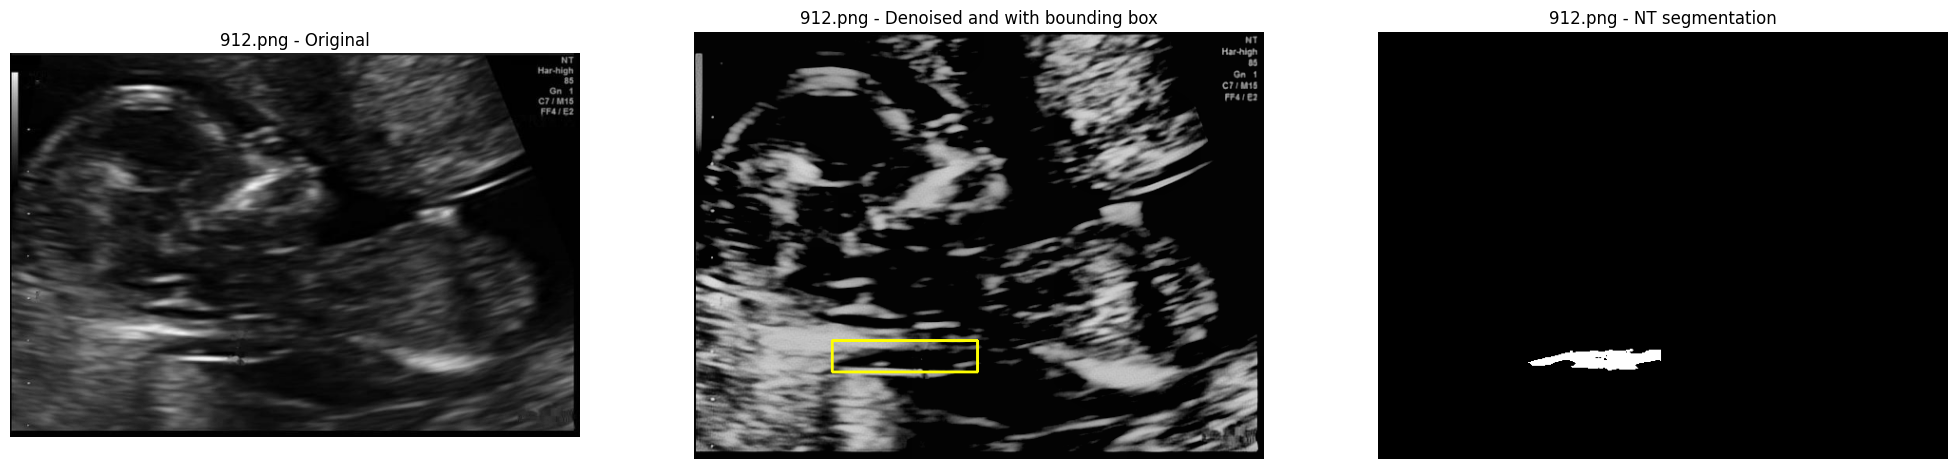

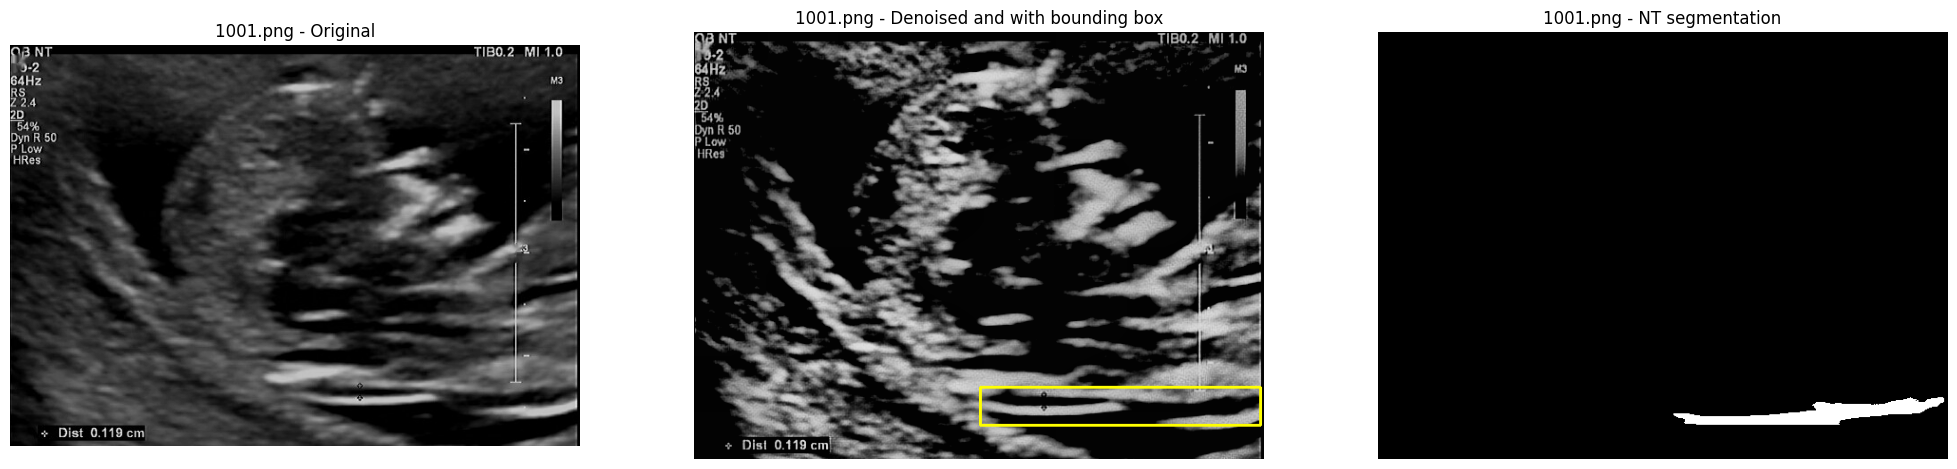

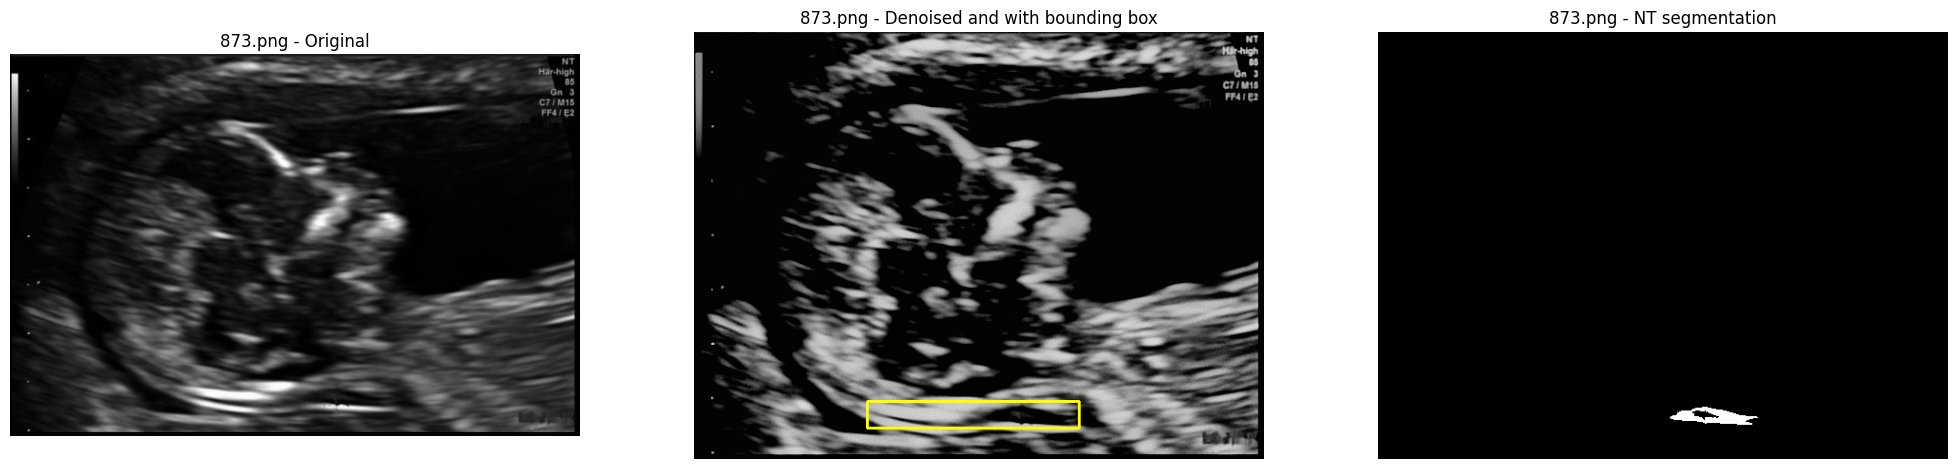

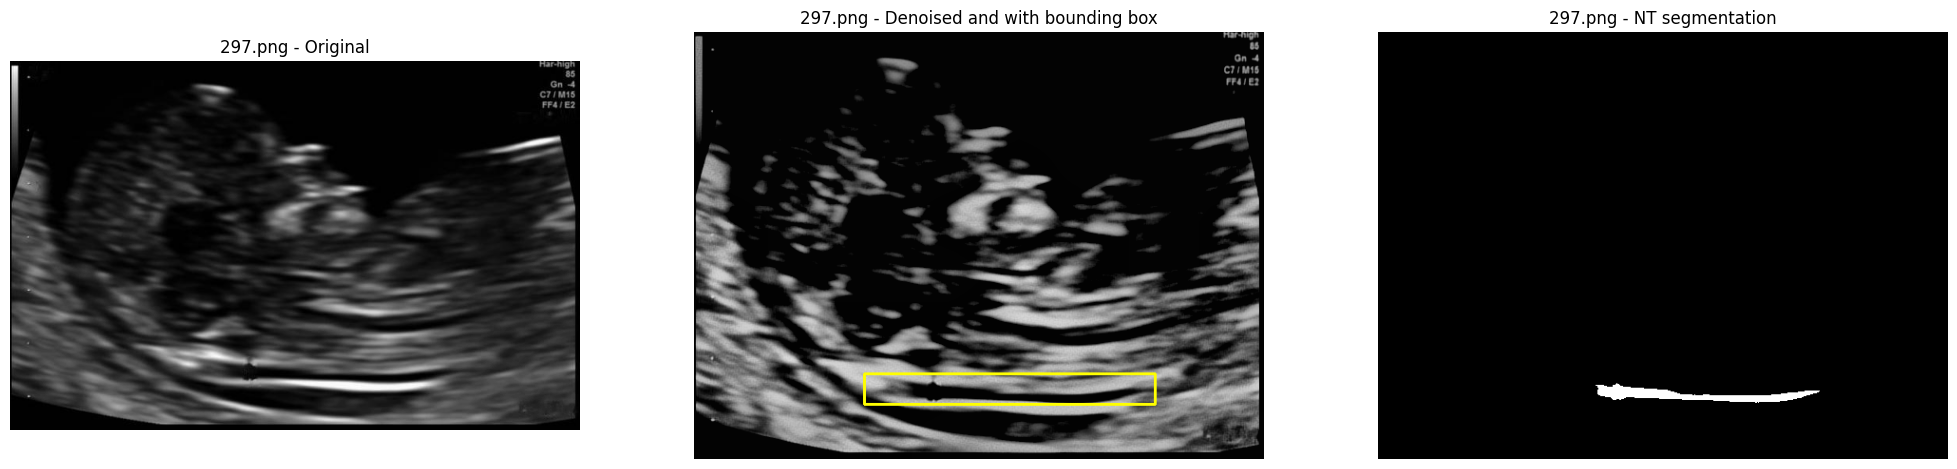

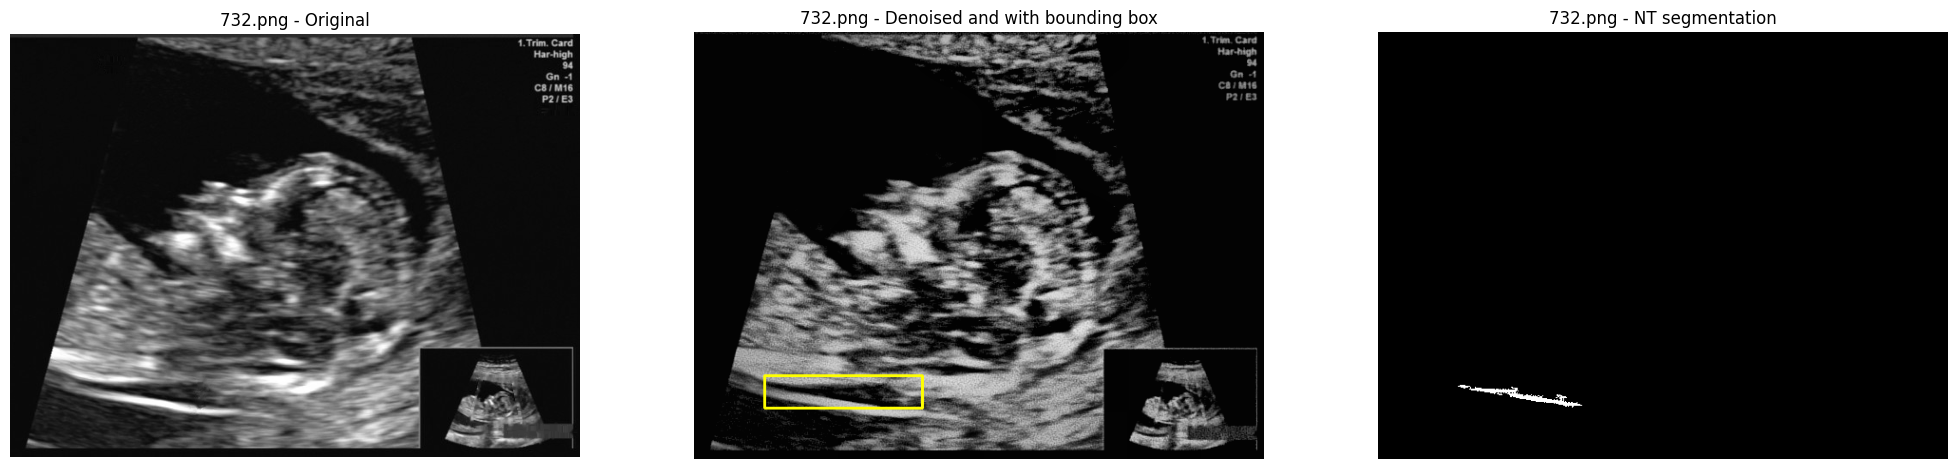

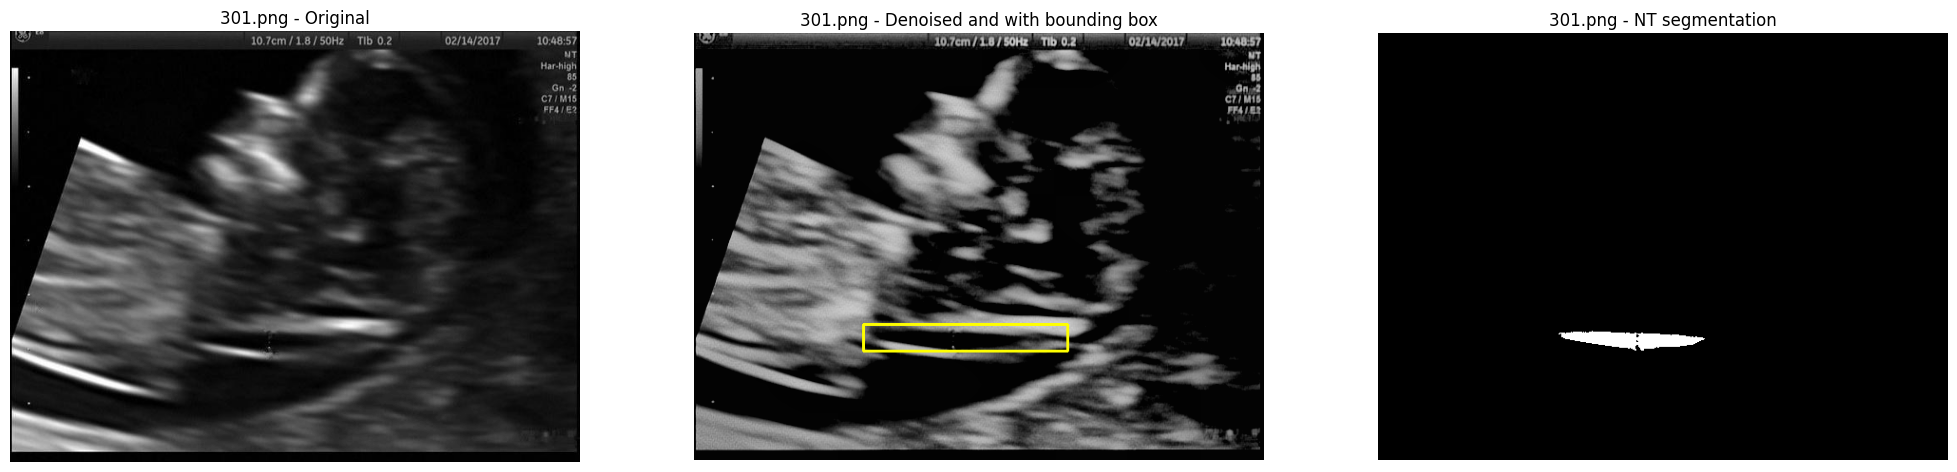

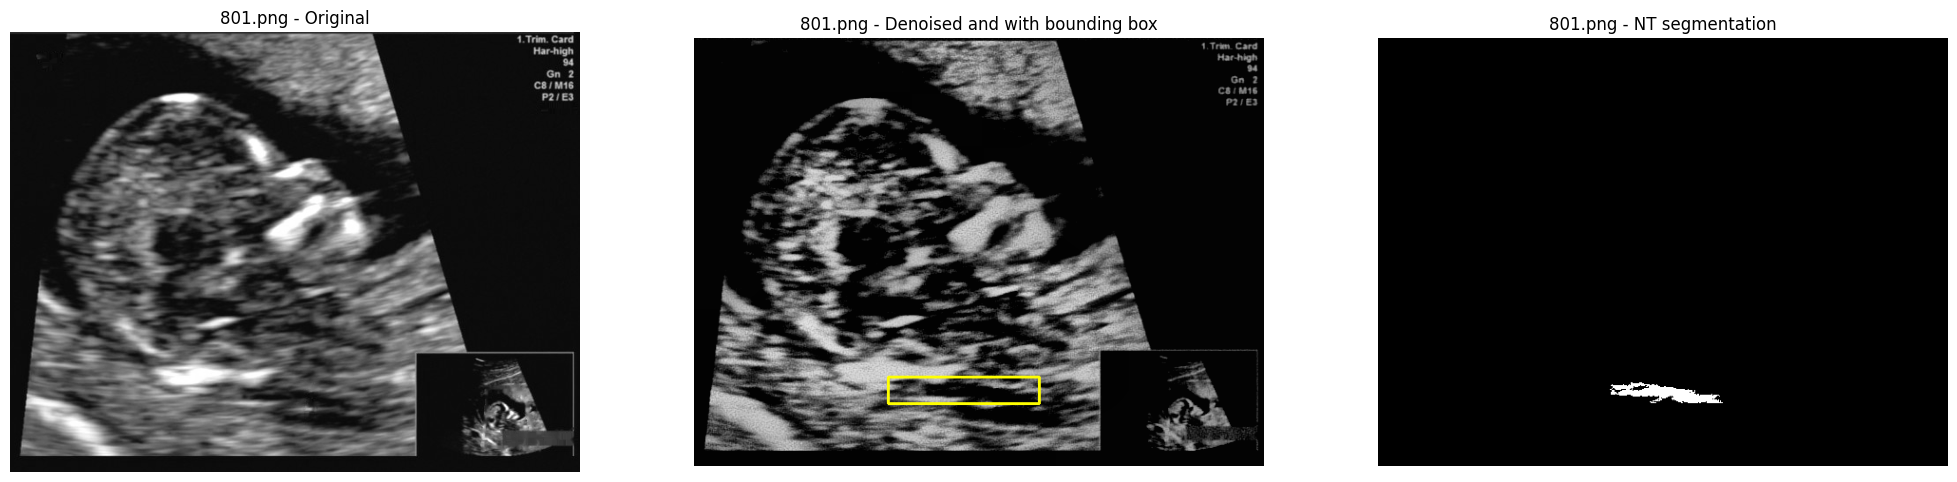

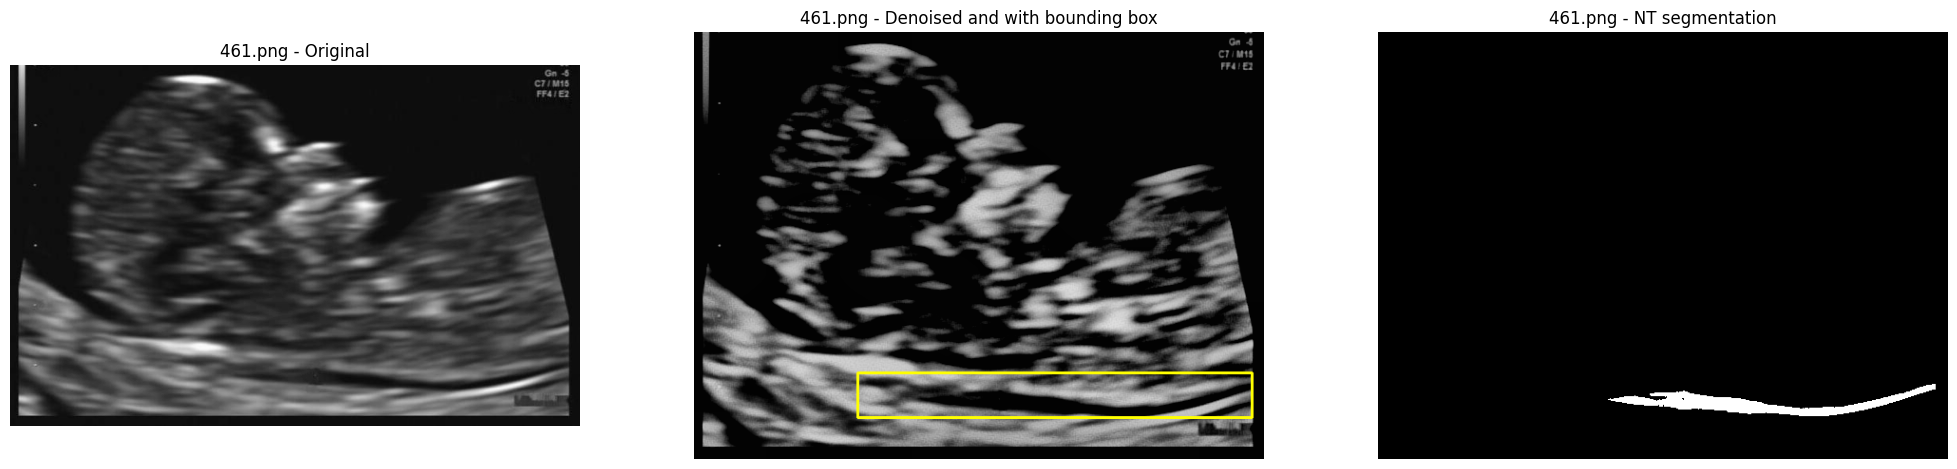

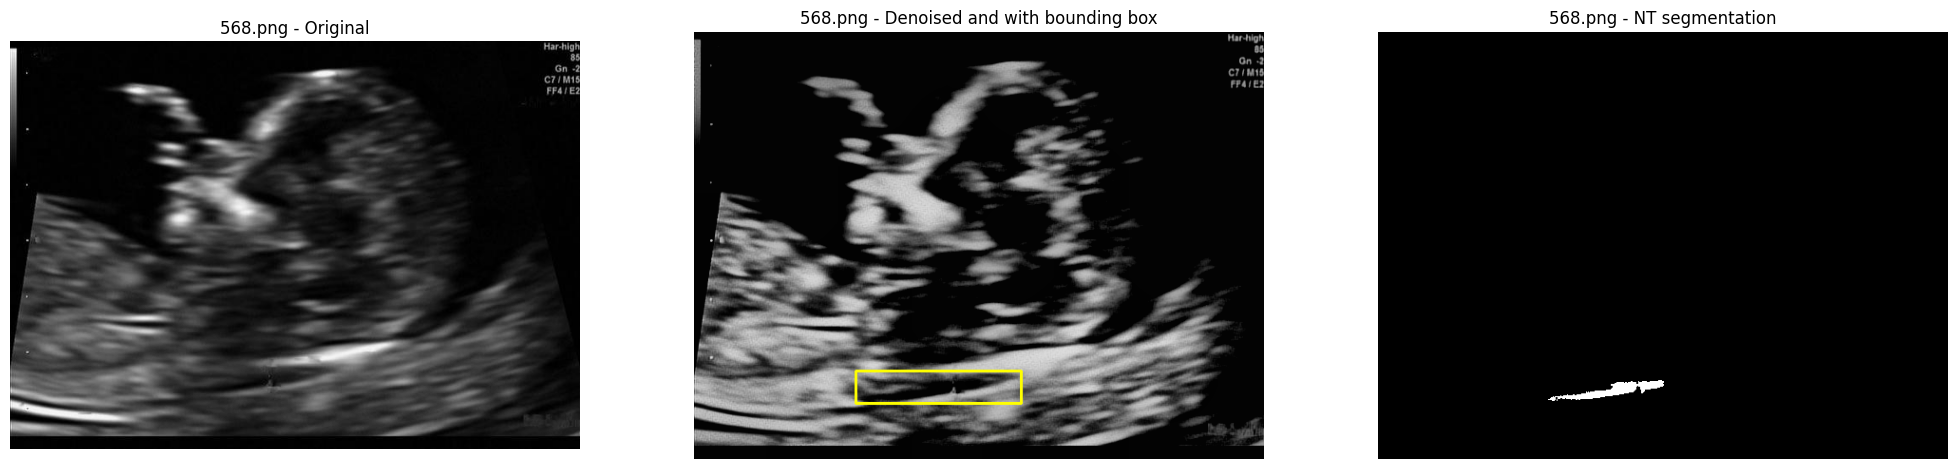

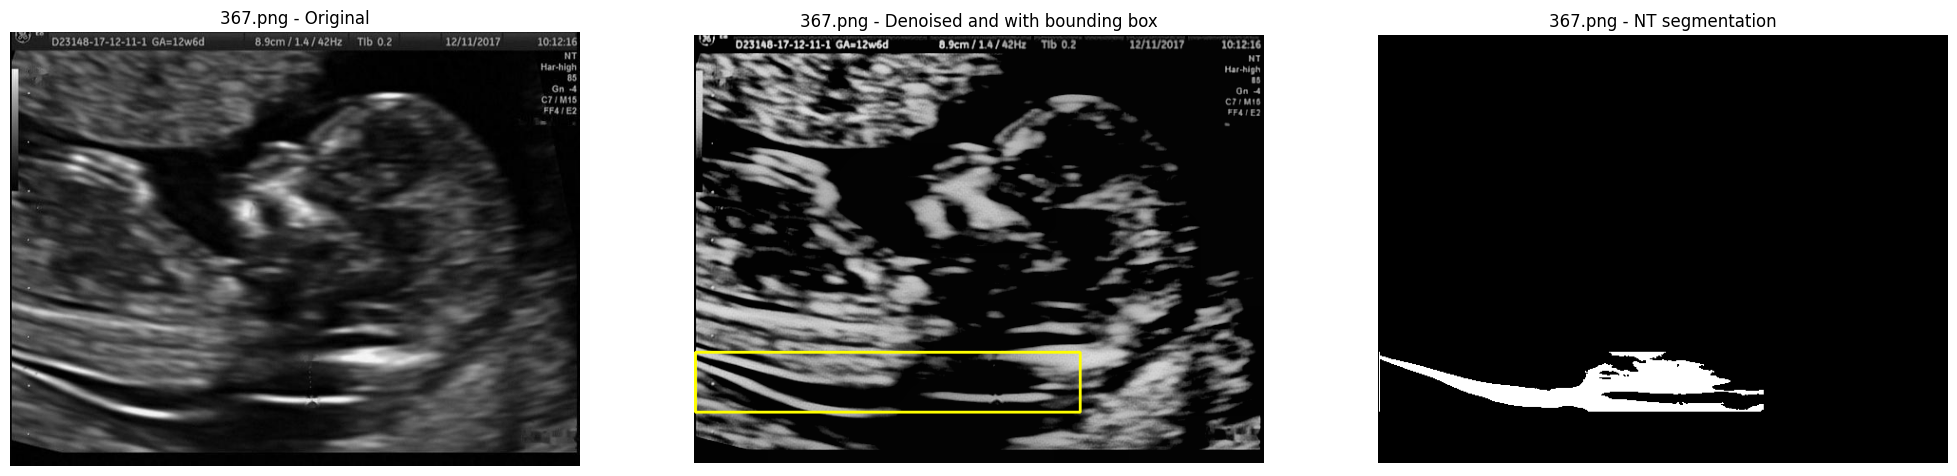

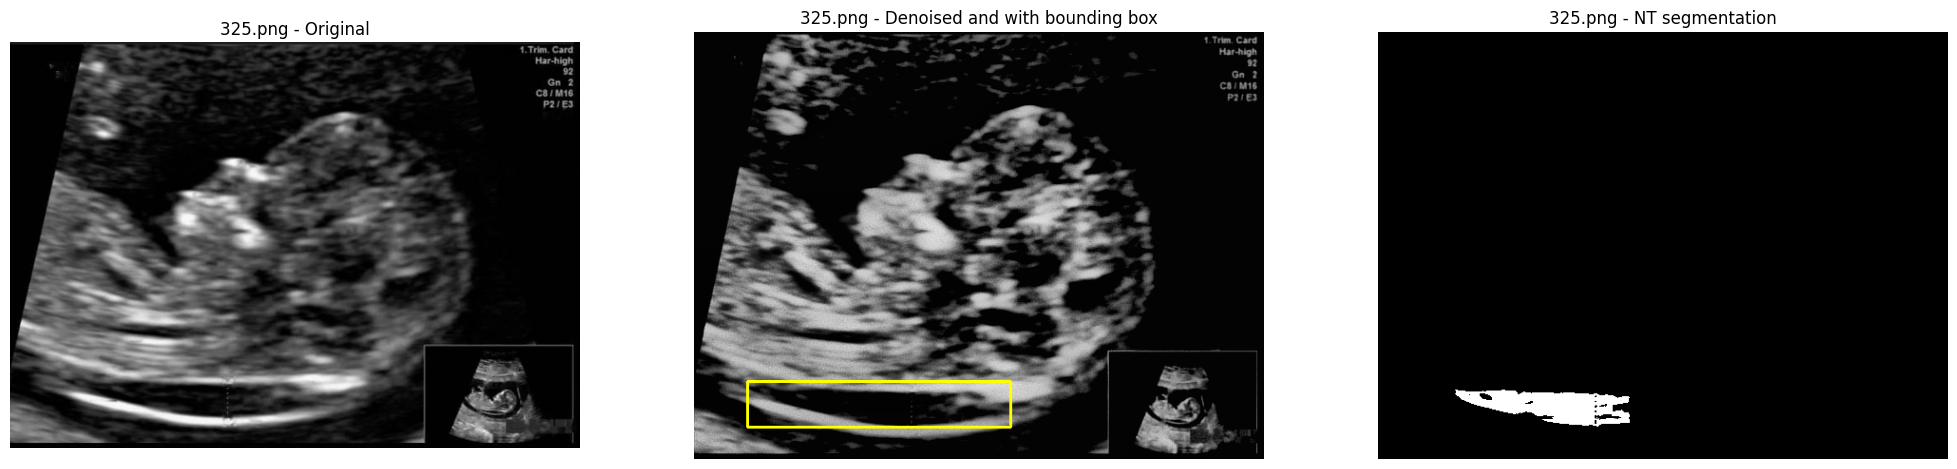

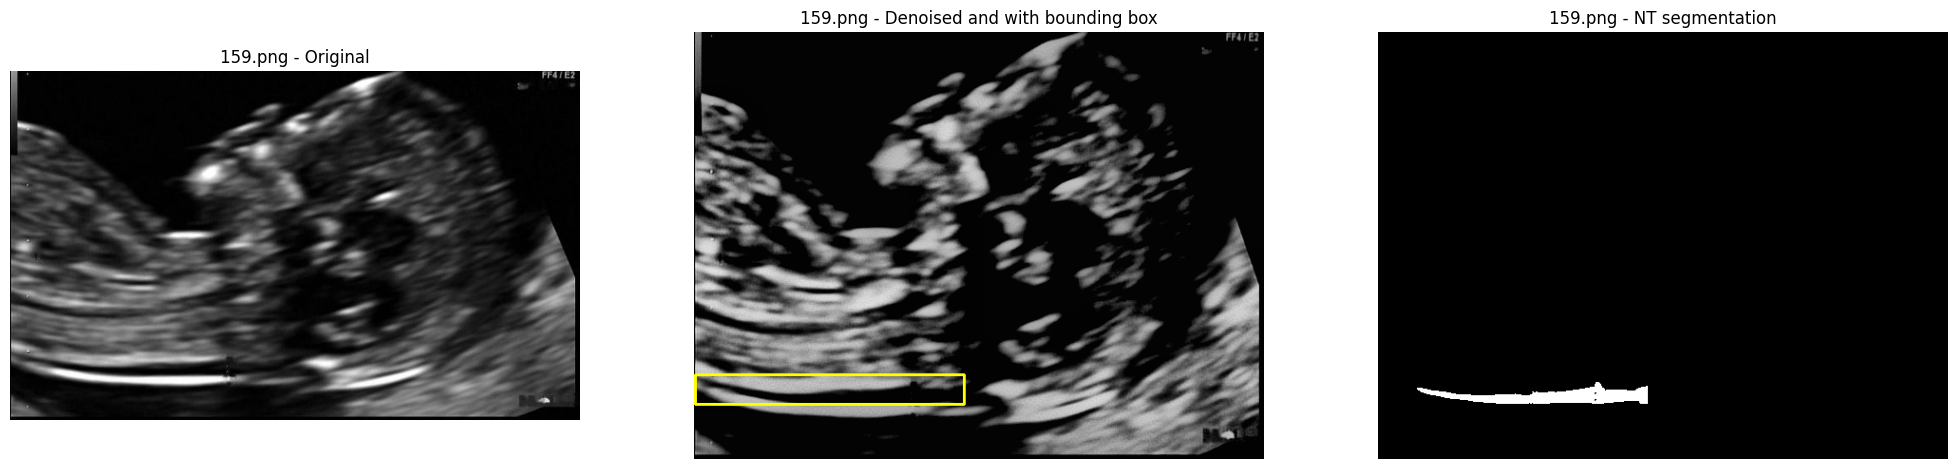

In [ ]:
# Gather the images paths
valid_ids = df_nt['fname'].unique()
resize_dim = (600, 450)
images = []
segmentations = []
image_ids = []
bounding_boxes = []

for dataset_standard_path in standard_dirs:
    for i, fname in enumerate(os.listdir(dataset_standard_path)):
        # Skip invalid files
        if not fname.endswith('.png') or fname not in valid_ids:
            continue

        image_ids.append(fname)
        img_raw = cv2.imread(os.path.join(dataset_standard_path, fname), cv2.IMREAD_GRAYSCALE)

        # Resize image
        img = cv2.resize(img_raw, resize_dim)

        # Denoising
        img = lukinoising(img)

        # Equalize histogram to improve contrast using CLAHE
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        img = clahe.apply(img)

        # Convert to color image
        img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

        # Get the bounding box coordinates
        h_min = df_nt[df_nt['fname'] == fname]['h_min'].values[0]
        h_max = df_nt[df_nt['fname'] == fname]['h_max'].values[0]
        w_min = df_nt[df_nt['fname'] == fname]['w_min'].values[0]
        w_max = df_nt[df_nt['fname'] == fname]['w_max'].values[0]

        # Resize the bounding box
        h_min = int(h_min * img.shape[0] / img_raw.shape[0])
        h_max = int(h_max * img.shape[0] / img_raw.shape[0])
        w_min = int(w_min * img.shape[1] / img_raw.shape[1])
        w_max = int(w_max * img.shape[1] / img_raw.shape[1])

        bounding_boxes.append(np.array([h_min, w_min, h_max, w_max]))

        ##############################
        # NT segmentation
        ##############################
        img_saved = img.copy()

        # Apply high pass filter to the image
        img = cv2.GaussianBlur(img_raw, (5, 5), 0)
        img = cv2.subtract(img, cv2.GaussianBlur(img, (5, 5), 0))
        img_hp = img.copy()

        # Binarize using otsu
        _, img = cv2.threshold(img_saved, 0, 255, cv2.THRESH_OTSU)
        img_otsu = img.copy()

        # Use mathematical morphology to remove small objects, and smooth
        kernel = np.ones((3, 3), np.uint8)
        img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
        img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
        img_open_close = img.copy()

        # Apply labeling segmentation
        img_inside_bb = img[h_min:h_max, w_min:w_max]
        labels = label(img_inside_bb, connectivity=1)

        # The most common label contains the NT
        nt_label = labels == 0

        # Pick the centroid of this label as the seed for a flood fill applied to the otsu binarized image
        # NOTE: The flood is applied to the otsu binarized image without high pass filtering
        img_roi = img_saved[h_min:h_max, w_min:w_max]
        nt_points = np.argwhere(nt_label)
        centroid = nt_points.mean(axis=0).astype(int)
        x_seed, y_seed = centroid
        nt_segmentation = skimage.segmentation.flood(img_roi, (x_seed, y_seed), tolerance=1)

        # Sometimes, the segmentation is too small, so we randomly move the seed point and try again
        n_iter = 0
        max_iter = 50
        roi_area = img_roi.shape[0] * img_roi.shape[1]
        while nt_segmentation.sum() < 0.1*roi_area and n_iter < max_iter:
            n_iter += 1
            x_seed = np.random.randint(img_roi.shape[0])
            y_seed = np.random.randint(img_roi.shape[1])
            nt_segmentation = skimage.segmentation.flood(img_roi, (x_seed, y_seed), tolerance=1)

            
        # Draw the segmentation as a binary image of the same shape as the original
        segmentation = np.zeros_like(img)
        segmentation[h_min:h_max, w_min:w_max] = nt_segmentation * 255

        # Draw one of every 100 images
        if not i % 100:
            fig, axs = plt.subplots(1, 3, figsize=(25, 10))
            img_rect = cv2.rectangle(img_color.copy(), (w_min, h_min), (w_max, h_max), (255, 255, 0), 2)

            axs[0].imshow(img_raw, cmap='gray')
            axs[0].axis('off')
            axs[0].set_title(f"{fname} - Original")

            axs[1].imshow(img_rect, cmap='gray')
            axs[1].axis('off')
            axs[1].set_title(f"{fname} - Denoised and with bounding box")

            axs[2].imshow(segmentation, cmap='gray')
            axs[2].axis('off')
            axs[2].set_title(f"{fname} - NT segmentation")

            plt.show()

        images.append(img_color)
        segmentations.append(segmentation)

# Lectura y preprocesamiento de datos

In [ ]:
# Librerías
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import cv2

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Dropout, BatchNormalization, Concatenate, Conv2DTranspose, ZeroPadding2D, Activation, MaxPool2D
from keras.regularizers import l2,l1,L1L2
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.metrics import Precision, SensitivityAtSpecificity, Accuracy
from keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast, RandomTranslation
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import MeanSquaredError
import tensorflow.keras.backend as K

from sklearn.model_selection import train_test_split
import random

In [2]:
path = "/kaggle/input/fetus-segmentation/"

dir_list = os.listdir(path)
print("Files and directories in '", path, "' :")
# prints all files
print(dir_list)

path_preprocessed_images = path + 'preprocessed_images/'
path_segmentations = path + 'segmentations/'

Files and directories in ' /kaggle/input/fetus-segmentation/ ' :
['preprocessed_images', 'segmentations']


In [3]:
list_paths_preprocessed_images = [path_preprocessed_images+file for file in os.listdir(path_preprocessed_images)]
list_paths_segmentations = [path_segmentations+file for file in os.listdir(path_segmentations)]

list_paths_preprocessed_images.sort()
list_paths_segmentations.sort()

In [5]:
images = np.float32(np.array([cv2.resize(cv2.imread(path,cv2.COLOR_GRAY2RGB), (300, 225))/255.0 for path in list_paths_preprocessed_images]))

segmentations = np.array([cv2.resize(cv2.imread(path), (300, 225))[:,:,0]/255.0 for path in list_paths_segmentations])

Agregamos una tercera dimensión a las imágenes, para tratarlas como entidades tridimensionales de canal único.

(1110, 225, 300, 1)


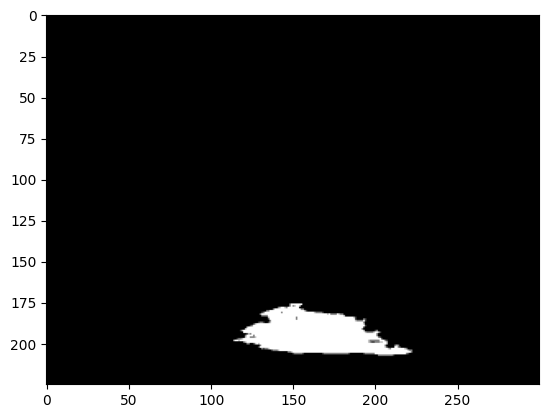

In [6]:
def new_dim(img):
    segs = np.empty((225,300,1))
    segs[:,:,0] = img
    return segs

segmentations_2 = np.array([new_dim(img) for img in segmentations])
print(np.shape(segmentations_2))

plt.imshow(segmentations_2[0],cmap='gray')
plt.show()

In [7]:
def binarization(img):
    new_img = img.copy()
    new_img[img >= 0.5] = 1
    new_img[img < 0.5] = 0

    return new_img

segmentations_prepro = np.uint8(np.array([binarization(img) for img in segmentations_2]))

In [27]:
def segmentationDemo(img,segmentation):

    img_color = img.copy()
    
    indexes2 = np.argwhere(segmentation==1)
    
    img_color[:,:,0][indexes2[:,0],indexes2[:,1]] = 0
    img_color[:,:,1][indexes2[:,0],indexes2[:,1]] = 255
    img_color[:,:,2][indexes2[:,0],indexes2[:,1]] = 255
    
    return img_color

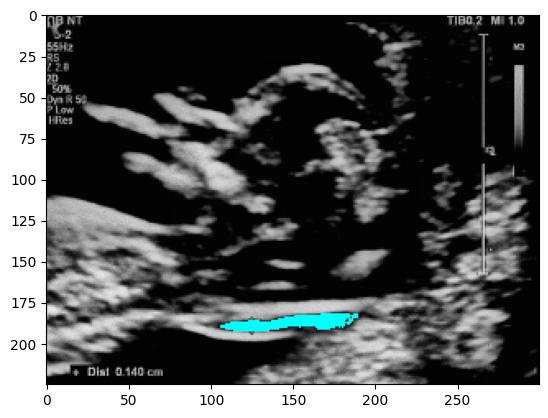

In [28]:
img_demo = segmentationDemo(images[12],segmentations_prepro[12])

plt.imshow(img_demo)
plt.show()

# Split de datos

In [11]:
# Train-test split
X_train, X_val, y_train, y_val = train_test_split(images, segmentations_prepro, test_size=0.1)

# Example: Display the shape of the train and test sets
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)

X_train shape: (999, 225, 300, 3)
X_val shape: (111, 225, 300, 3)
y_train shape: (999, 225, 300, 1)
y_val shape: (111, 225, 300, 1)


# Modelo
Para llevar a cabo la tarea de segmentación semántica, con el objetivo de generar máscaras binarias representativas del área de interés, se utilizó una red neuronal U-NET, basada en bloques convolucionales y de pooling.

In [15]:
# Sensibilidad (Recall)
def sensitivity(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    true_positives = K.sum(y_true * y_pred)
    possible_positives = K.sum(y_true)
    return true_positives / (possible_positives + K.epsilon())

# Especificidad
def specificity(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    true_negatives = K.sum((1 - y_true) * (1 - y_pred))
    possible_negatives = K.sum(1 - y_true)
    return true_negatives / (possible_negatives + K.epsilon())

In [16]:
# Define ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                              factor=0.75, 
                              patience=8, 
                              min_lr=1e-6, 
                              verbose=1)

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', 
                               patience=10, 
                               verbose=1, 
                               restore_best_weights=True)

In [17]:
def encoder_block(inputs, num_filters): 
    # Convolution with 3x3 filter followed by ReLU activation
    x = Conv2D(num_filters, 3, padding='same')(inputs) 
    x = Activation('relu')(x) 

    # Convolution with 3x3 filter followed by ReLU activation
    x = Conv2D(num_filters, 3, padding='same')(x) 
    x = Activation('relu')(x) 

    # Max Pooling with 2x2 filter
    p = MaxPool2D(pool_size=(2, 2))(x) 
    return x, p

def decoder_block(inputs, skip_features, num_filters): 
    # Upsampling with 2x2 filter
    x = Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(inputs) 

    # Ensure the shapes match by cropping or padding
    if x.shape[1] != skip_features.shape[1] or x.shape[2] != skip_features.shape[2]:
        x = ZeroPadding2D(((0, skip_features.shape[1] - x.shape[1]), (0, skip_features.shape[2] - x.shape[2])))(x)

    # Concatenate skip connections
    x = Concatenate()([x, skip_features]) 

    # Convolution with 3x3 filter followed by ReLU activation
    x = Conv2D(num_filters, 3, padding='same')(x) 
    x = Activation('relu')(x) 

    # Convolution with 3x3 filter followed by ReLU activation
    x = Conv2D(num_filters, 3, padding='same')(x) 
    x = Activation('relu')(x) 
    return x

def unet_model(input_shape=(100, 100, 3), num_classes=1): 
    inputs = Input(input_shape) 
    
    # Contracting Path
    s1, p1 = encoder_block(inputs, 64) 
    s2, p2 = encoder_block(p1, 128) 
    s3, p3 = encoder_block(p2, 256) 
    s4, p4 = encoder_block(p3, 512) 
    
    # Bottleneck
    b1 = Conv2D(1024, 3, padding='same')(p4) 
    b1 = Activation('relu')(b1) 
    b1 = Conv2D(1024, 3, padding='same')(b1) 
    b1 = Activation('relu')(b1) 
    
    # Expansive Path
    d1 = decoder_block(b1, s4, 512) 
    d2 = decoder_block(d1, s3, 256) 
    d3 = decoder_block(d2, s2, 128) 
    d4 = decoder_block(d3, s1, 64) 
    
    # Output Layer
    outputs = Conv2D(num_classes, 1, activation='sigmoid' if num_classes == 1 else 'softmax')(d4) 
    
    model = Model(inputs, outputs, name='U-Net') 
    return model

In [18]:
learning_rate = 0.001

from tensorflow import distribute
strategy = distribute.MirroredStrategy()

with strategy.scope():
    # instantiate your model here
    learning_rate = 0.001
    optimizer = Adam(learning_rate=learning_rate)
    model =  unet_model(input_shape=(225, 300, 3), num_classes=1)

model.compile(optimizer= optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 225, 300,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 225, 300,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 225, 300,  │          0 │ conv2d[0][0]      │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 225, 300,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 225, 300,  │          0 │ conv2d_1[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 150,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 112, 150,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 112, 150,  │          0 │ conv2d_2[0][0]    │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 112, 150,  │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 112, 150,  │          0 │ conv2d_3[0][0]    │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 75,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 75,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 56, 75,    │          0 │ conv2d_4[0][0]    │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 56, 75,    │    590,080 │ activation_4[0][… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 56, 75,    │          0 │ conv2d_5[0][0]    │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 28, 37,    │          0 │ activation_5[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 28, 37,    │  1,180,160 │ max_pooling2d_2[

 Total params: 31,031,745 (118.38 MB)

 Trainable params: 31,031,745 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

## Entrenamiento del modelo

In [19]:
history = model.fit(
    x = X_train,
    y = y_train,
    validation_data = (X_val,y_val),
    batch_size = 32,
    epochs = 20,
    callbacks = [reduce_lr, early_stopping]
)

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.8705 - loss: 0.5850 - val_accuracy: 0.9917 - val_loss: 0.0546 - learning_rate: 0.0010
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 29s 891ms/step - accuracy: 0.9919 - loss: 0.0506 - val_accuracy: 0.9917 - val_loss: 0.0362 - learning_rate: 0.0010
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 30s 946ms/step - accuracy: 0.9918 - loss: 0.0361 - val_accuracy: 0.9917 - val_loss: 0.0282 - learning_rate: 0.0010
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 32s 980ms/step - accuracy: 0.9914 - loss: 0.0323 - val_accuracy: 0.9917 - val_loss: 0.0240 - learning_rate: 0.0010
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 30s 932ms/step - accuracy: 0.9918 - loss: 0.0263 - val_accuracy: 0.9917 - val_loss: 0.0229 - learning_rate: 0.0010
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 31s 963ms/step - accuracy: 0.9917 - loss: 0.0229 - val_accuracy: 0.9944 - val_loss: 0.0190 - learning_rate: 0.0010
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 31s 972ms/step - accuracy: 0.9934 - loss: 0.017

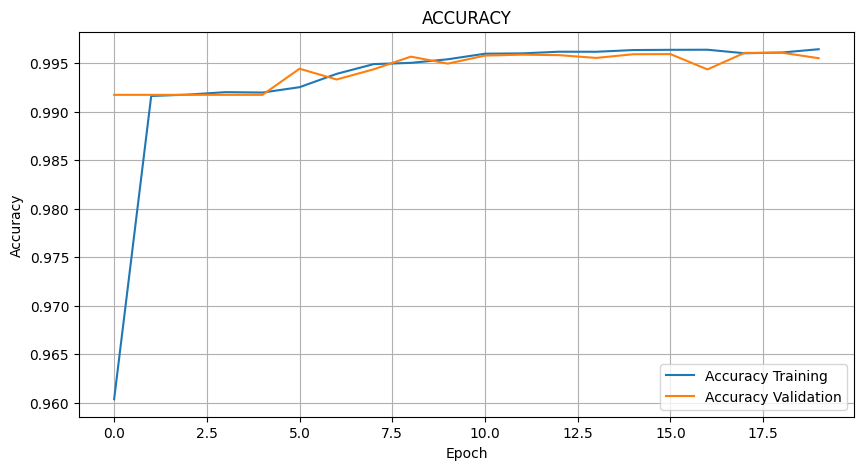

In [44]:
fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(1,1,1)
ax.plot(history.history['accuracy'],label='Accuracy Training')
ax.plot(history.history['val_accuracy'],label='Accuracy Validation')
ax.set_title('ACCURACY')
ax.legend(loc='lower right')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.grid()
plt.show()

## Evaluación de resultados

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


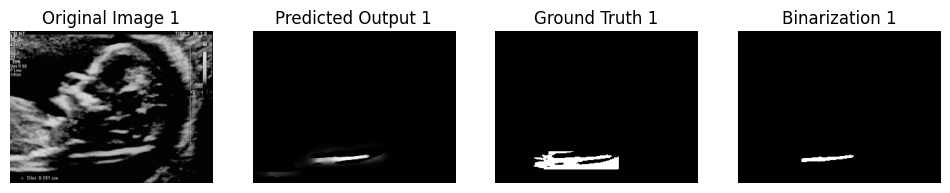

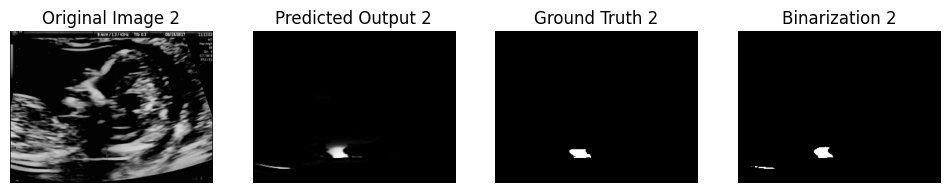

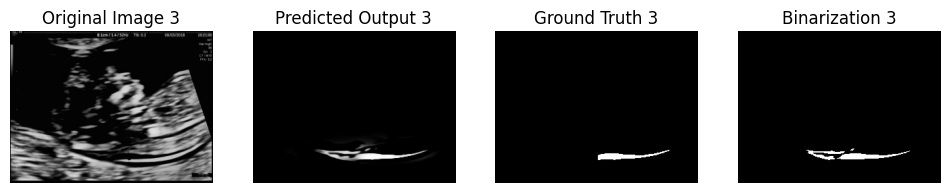

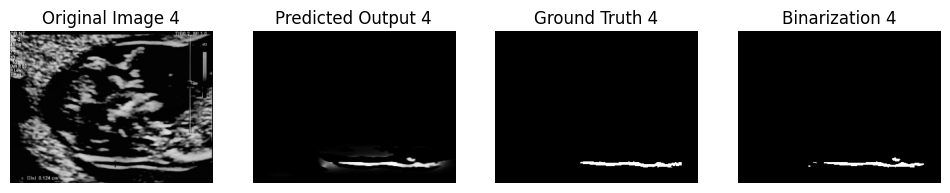

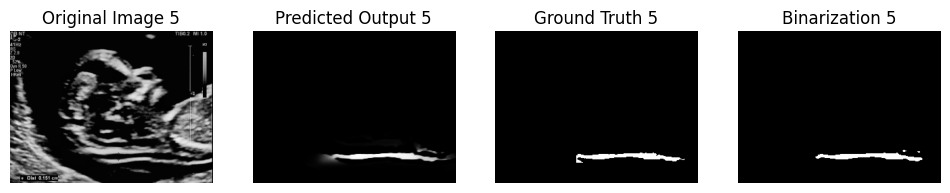

In [29]:
y_pred = model.predict(X_val[:5])  # Predict on the first 5 validation images

# Create a plot to compare original, predicted, and validation images
for i in range(5):  # Show the first 5 images
    plt.figure(figsize=(12, 4))

    # Original image (input image to the model)
    plt.subplot(1, 4, 1)
    plt.imshow(X_val[i])
    plt.title(f"Original Image {i+1}")
    plt.axis('off')

    # Predicted output (the model's output)
    plt.subplot(1, 4, 2)
    plt.imshow(y_pred[i], cmap='gray')  # Use grayscale for segmentation maps
    plt.title(f"Predicted Output {i+1}")
    plt.axis('off')

    # Validation image (ground truth mask)
    plt.subplot(1, 4, 3)
    plt.imshow(y_val[i], cmap='gray')
    plt.title(f"Ground Truth {i+1}")
    plt.axis('off')

    # Binarization of the output image
    y_bin = y_pred[i] > 0.5
    plt.subplot(1, 4, 4)
    plt.imshow(y_bin, cmap='gray')
    plt.title(f"Binarization {i+1}")
    plt.axis('off')

    # Display the plot
    plt.show()

In [34]:
def getBinarization(img_predicha,alpha=0.5):
    img = img_predicha.copy()
    img[img_predicha >= alpha] = 1
    img[img_predicha < alpha] = 0

    return img

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


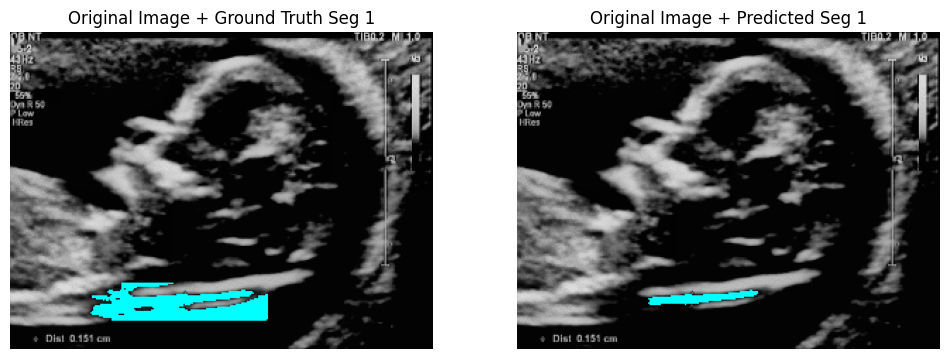

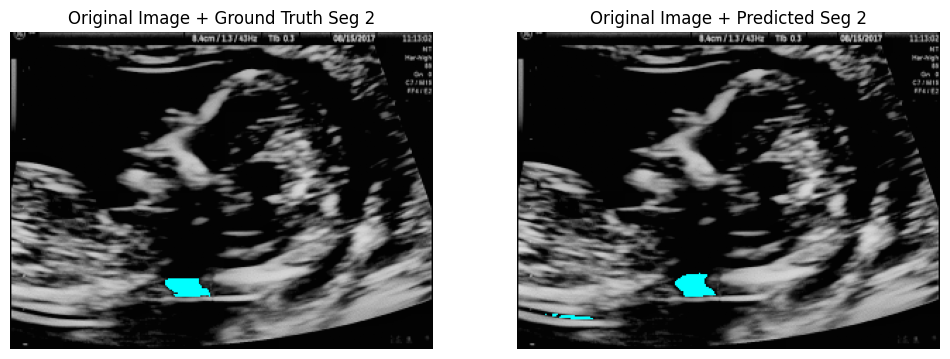

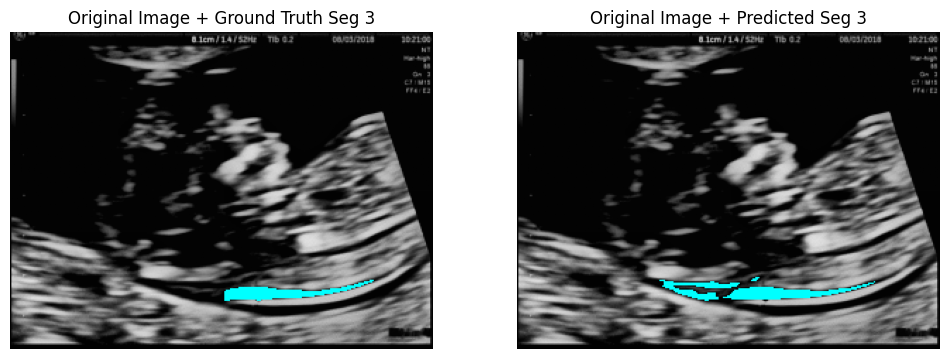

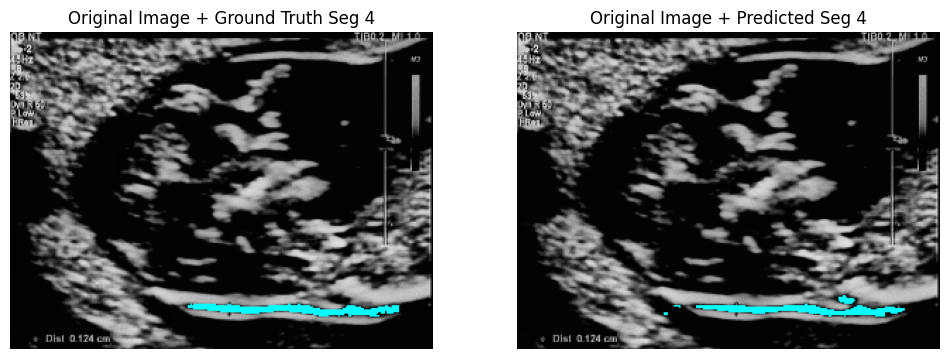

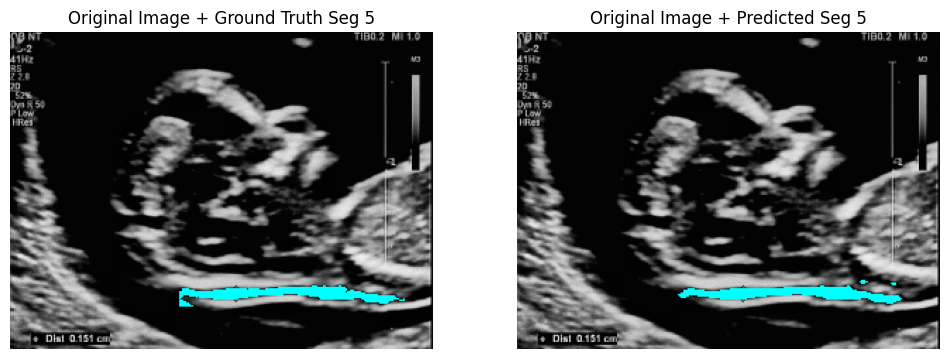

In [35]:
y_pred = model.predict(X_val[:5])  # Predict on the first 5 validation images

# Create a plot to compare original, predicted, and validation images
for i in range(5):  # Show the first 5 images
    plt.figure(figsize=(12, 7))

    truth_seg_plus_image = segmentationDemo(X_val[i],y_val[i])

    predicted_segmentation = getBinarization(y_pred[i])

    pred_seg_plus_image = segmentationDemo(X_val[i],predicted_segmentation)
    
    plt.subplot(1, 2, 1)
    plt.imshow(truth_seg_plus_image)
    plt.title(f"Original Image + Ground Truth Seg {i+1}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(pred_seg_plus_image)
    plt.title(f"Original Image + Predicted Seg {i+1}")
    plt.axis('off')
    
    # Display the plot
    plt.show()

## Conclusiones de la segmentación
Los resultados obtenidos han sido satisfactorios, teniendo en cuenta que las segmentaciones para el entrenamiento de la U-Net fueron creadas mediante un algoritmo propio que las realizaba de manera conjunta. Es decir, no se realizó una segmentación individual, por lo que existen casos en los que la segmentación considerada como "realidad" (Ground Truth) no era perfecta. Debido a ello, es interesante cómo las predicciones del modelo en ocaciones superan a la Ground Truth, como en el caso de la imagen 1 de la figura anterior. Esto indica una comprensión semántica del área anecogénica. Sin embargo, hay ocasiones donde el modelo no es perfecto, y se cometen errores.